In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix,accuracy_score

In [13]:
#-------------------------------------------------------------------------------
#-----------------------------GENERALS------------------------------------------
#-------------------------------------------------------------------------------

#--------------------------all features-----------------------------------------
features = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 
            'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 
            'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 
            'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
            'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
            'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','label']
#-------------------------------------------------------------------------------

#-------------selected featues--------------------------------------------------
#discrete features
discrete_features = ['protocol_type','service','flag','land','logged_in',
                     'root_shell','su_attempted','is_host_login','is_guest_login']
#continuous features:
continuous_features = ['duration','src_bytes','dst_bytes','wrong_fragment',
                       'urgent','hot','num_failed_logins','num_root',
                       'num_access_files','num_outbound_cmds',
         'count','srv_count','serror_rate','srv_serror_rate','rerror_rate',
         'srv_rerror_rate','num_file_creations','num_shells','same_srv_rate',
         'diff_srv_rate']
#-------------------------------------------------------------------------------

#-------------DoS attack types--------------------------------------------------
dos_attacks = ['back.','land.','neptune.','pod.','smurf.','teardrop.']
#-------------------------------------------------------------------------------

In [14]:
#-------------------------------------------------------------------------------
#---------------------------------HELPER FUNCTIONS------------------------------
#-------------------------------------------------------------------------------

#----------------------------------normalize------------------------------------
#purpose: z-scores features
#inputs: 
#       dataset: numpy-like array of samples (continuous only)
#       feature_list : list of continuous features to be normalized
#outputs: -

def normalize(dataset,feature_list):
  scaler = StandardScaler() #from sklearn
  for i in feature_list:
    dataset[i] = scaler.fit_transform(dataset[i].values.reshape(-1,1))
#-------------------------------------------------------------------------------

#--------------------------------preprocess-------------------------------------
#purpose : preprocessing raw data
#inputs:
#       dataset : raw dataset
#output:
#       returns normalized, reduced version of the dataset

def preprocess(dataset):
  disc_feats = dataset[discrete_features] #extract selected discrete features
  cont_feats = dataset[continuous_features] #extract selected continuous features

  #sparse categorical encoding for discrete string-vaulued features
  disc_feats['protocol_type'] = disc_feats['protocol_type'].astype('category').cat.codes
  disc_feats['service'] = disc_feats['service'].astype('category').cat.codes
  disc_feats['flag'] = disc_feats['flag'].astype('category').cat.codes
  
  #normalizing continuous features
  normalize(cont_feats,continuous_features) 

  #putting preprocessed discrete and continuous features together
  final_dataset = np.hstack([disc_feats,cont_feats])  
  return final_dataset
#-------------------------------------------------------------------------------


#---------------------------------adjust labels---------------------------------
#purpose: adjusting labels
#inputs:
#       dataset : numpy array of samples
#outputs:
#       returns proper labels for samples

def adjust_labels(dataset):
  y = []
  for d in dataset['label'].values:
    if(d in dos_attacks):
      y.append(1) #if DoS
    else:
      y.append(-1) #if Not DoS
  return y
#-------------------------------------------------------------------------------

In [15]:
#-------------------------------------------------------------------------------
#---------------------------------IMPLEMENTATION--------------------------------
#-------------------------------------------------------------------------------

#----------------------------------------------------------------
#-----------------------Load Dataset-----------------------------
#----------------------------------------------------------------
train_dataset = pd.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz',compression='gzip',header = 0,names = features)
test_dataset = pd.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz',compression='gzip',header = 0,names = features)
#-----------------------------------------------------------------

#drop duplicates------------------------------
train_dataset.drop_duplicates(subset=features,keep='first',inplace=True)
test_dataset.drop_duplicates(subset=features,keep='first',inplace=True)
#---------------------------------------------

#----------adjust labels----------------------
y_train = adjust_labels(train_dataset)
y_test = adjust_labels(test_dataset)

#----------preprocess-------------------------
x_train = preprocess(train_dataset)
x_test  = preprocess(test_dataset)
#---------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

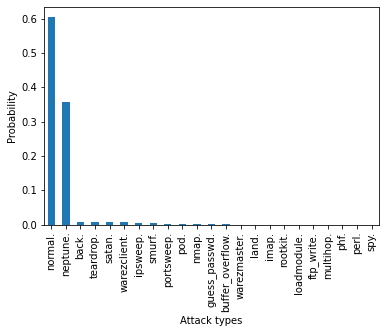

In [16]:
distro = train_dataset['label'].value_counts() / train_dataset.shape[0]
distro.plot(kind='bar')
plt.xlabel('Attack types')
plt.ylabel('Probability')
plt.show()

In [17]:
#-----------fitting an SVM Classifier---------
clf = svm.SVC(C = 0.8,gamma = 0.1)
clf.fit(x_train,y_train)
#---------------------------------------------

SVC(C=0.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [18]:
#---------Testing--------
p = clf.predict(x_test)
#------------------------

In [19]:
print("Classification Results for SVM:",'-'*10)
print("Accuracy: ",accuracy_score(p,y_test))
print("Precision: ",precision_score(y_test,p))
print("Recall: ",recall_score(y_test,p))
print("F1 Score: ",f1_score(y_test,p))
print('-'*45)

Classification Results for SVM: ----------
Accuracy:  0.982093646090748
Precision:  0.9549847861106139
Recall:  0.9825966850828729
F1 Score:  0.9685939911046564
---------------------------------------------


In [27]:
#--------------------Scores Per Classes--------------------
conf_mat = confusion_matrix(y_test,p)
TP = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TN = conf_mat[1][1]
prec_0 = TP/(TP + FP)
rec_0 = TP / (TP + FN)
f1_0 = 2* (prec_0 * rec_0)/(prec_0 + rec_0)
prec_1 = TN / (TN + FN)
rec_1 = TN / (TN + FP)
f1_1 = 2 * (prec_1 * rec_1)/(prec_1  +  rec_1)
print("Classes","Precision","Recall","F1 Score")
print("1",prec_0,rec_0,f1_0)
print("0 ",prec_1,rec_1,f1_1)
#-------------------------------------------------------------

Classes Precision Recall F1 Score
1 0.9818970326249302 0.9931201426933367 0.9874766997846427
0  0.9825966850828729 0.9549847861106139 0.9685939911046564
